In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import pandas as pd

In [2]:
# Define dataset directory
dataset_dir = "dataset"

# Get all images and their labels
image_paths = []
labels = []

image_names = os.listdir(dataset_dir)
class_names = set(['_'.join(img.split('_')[:2]) for img in image_names])
num_classes = len(class_names)

for img_name in image_names:
    image_paths.append(os.path.join(dataset_dir, img_name))
    label = '_'.join(img_name.split('_')[:2])
    labels.append(label)  # The folder name is the label

# Create a DataFrame
df = pd.DataFrame({"image_path": image_paths, "label": labels})

# Split into train (80%) and validation (20%)
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)

print(f"Training samples: {len(train_df)}, Validation samples: {len(val_df)}, Classes : {num_classes}")

Training samples: 204, Validation samples: 52, Classes : 14


In [3]:
def build_model(input_shape=(64, 64, 3), num_classes=num_classes):
    model = keras.Sequential([
        layers.Conv2D(64, (3, 3), activation="relu", input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(128, (3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),

        layers.Conv2D(256, (3, 3), activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(2, 2),

        layers.Flatten(),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.4),  # Prevent overfitting
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation="softmax")
    ])
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),  # Lower learning rate
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model


In [4]:
# Image Data Generators for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Rotate images randomly up to 30 degrees
    width_shift_range=0.2,  # Shift image horizontally
    height_shift_range=0.2,  # Shift image vertically
    brightness_range=[0.8, 1.2],  # Adjust brightness
    shear_range=0.2,  # Shear transformations
    zoom_range=0.2,  # Zoom-in/out transformations
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator(rescale=1./255)

# Load images from DataFrame
train_generator = train_datagen.flow_from_dataframe(
    train_df, x_col="image_path", y_col="label", target_size=(64, 64), batch_size=32, class_mode="sparse"
)

val_generator = val_datagen.flow_from_dataframe(
    val_df, x_col="image_path", y_col="label", target_size=(64, 64), batch_size=32, class_mode="sparse"
)

Found 204 validated image filenames belonging to 14 classes.
Found 52 validated image filenames belonging to 14 classes.


In [5]:
model = build_model()

history = model.fit(train_generator, 
                    validation_data=val_generator, 
                    epochs=20, 
                    verbose=1)

c:\Users\alexa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\alexa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 307ms/step - accuracy: 0.2596 - loss: 3.6588 - val_accuracy: 0.2500 - val_loss: 2.4688
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - accuracy: 0.4588 - loss: 3.3516 - val_accuracy: 0.2500 - val_loss: 2.3296
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step - accuracy: 0.4857 - loss: 2.3799 - val_accuracy: 0.2692 - val_loss: 2.2269
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step - accuracy: 0.4985 - loss: 2.2700 - val_accuracy: 0.3462 - val_loss: 2.1976
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - accuracy: 0.5271 - loss: 2.6816 - val_accuracy: 0.2500 - val_loss: 2.4579
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step - accuracy: 0.4854 - loss: 2.3762 - val_accuracy: 0.2885 - val_loss: 2.7267
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.5142 - loss: 2.3062 - val_accuracy: 0.5000 - val_loss: 2.6860
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 200ms/step - accuracy: 0.5308 - loss: 2.1275 - val_accuracy: 0.4808 - val_loss:

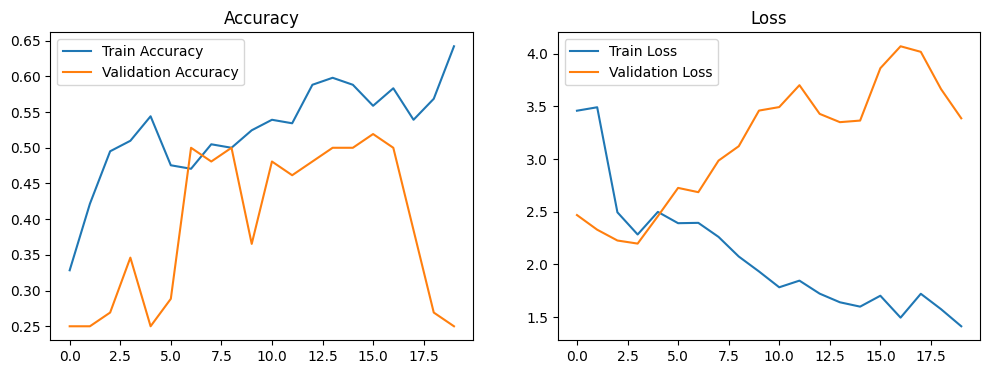

In [6]:
# Plot accuracy and loss curves
def plot_training_curves(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')

    plt.show()

plot_training_curves(history)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


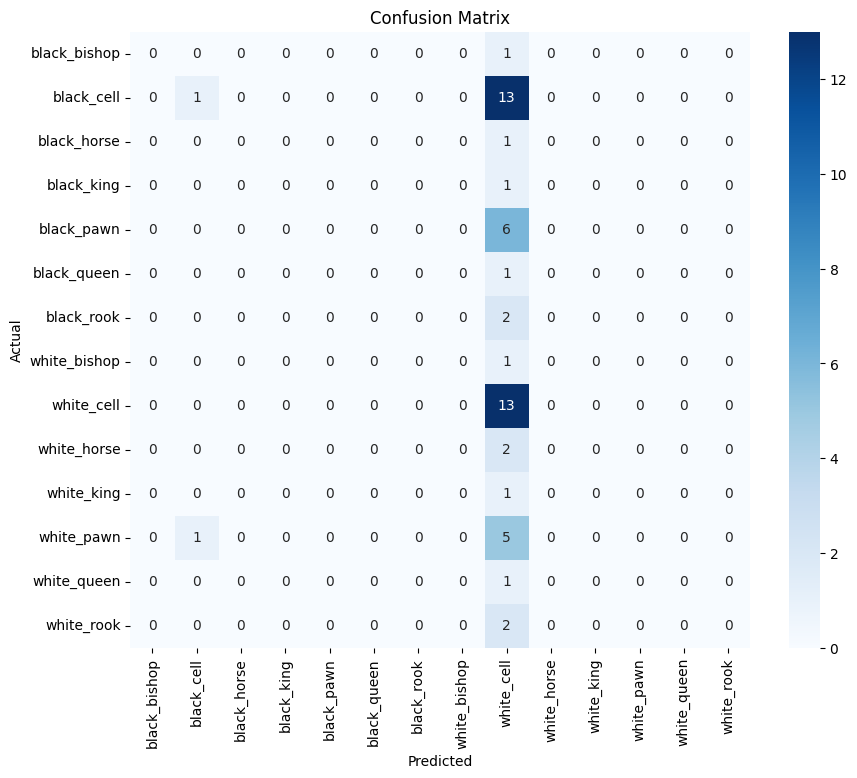

              precision    recall  f1-score   support

black_bishop       0.00      0.00      0.00         1
  black_cell       0.50      0.07      0.12        14
 black_horse       0.00      0.00      0.00         1
  black_king       0.00      0.00      0.00         1
  black_pawn       0.00      0.00      0.00         6
 black_queen       0.00      0.00      0.00         1
  black_rook       0.00      0.00      0.00         2
white_bishop       0.00      0.00      0.00         1
  white_cell       0.26      1.00      0.41        13
 white_horse       0.00      0.00      0.00         2
  white_king       0.00      0.00      0.00         1
  white_pawn       0.00      0.00      0.00         6
 white_queen       0.00      0.00      0.00         1
  white_rook       0.00      0.00      0.00         2

    accuracy                           0.27        52
   macro avg       0.05      0.08      0.04        52
weighted avg       0.20      0.27      0.14        52



c:\Users\alexa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alexa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\alexa\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [7]:
# Get true labels and predictions
y_true = val_generator.classes
y_pred = np.argmax(model.predict(val_generator), axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=train_generator.class_indices.keys(), 
            yticklabels=train_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=train_generator.class_indices.keys()))


In [ ]:
for _, row in val_df.head(2).iterrows():
    img = plt.imread(row['image_path'])
    prediction = model.predict(img)
    plt.imshow(img)
    plt.title(f"""
    image : {row['label']}
    prediction : {prediction}          
    """)
    
plt.plot()

c:\Users\alexa\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_3
Received: inputs=('Tensor(shape=(32, 64, 4))',)
  warnings.warn(msg)


ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32, 64, 4), dtype=float32). Expected shape (None, 64, 64, 3), but input has incompatible shape (32, 64, 4)[0m

Arguments received by Sequential.call():
  • inputs=('tf.Tensor(shape=(32, 64, 4), dtype=float32)',)
  • training=False
  • mask=('None',)

In [9]:
# Convert to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model
mobile_model_path = os.path.join(
    'chess_piece_model.tflite'
)

with open(mobile_model_path, "wb") as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\alexa\AppData\Local\Temp\tmp3fraqwfp\assets


INFO:tensorflow:Assets written to: C:\Users\alexa\AppData\Local\Temp\tmp3fraqwfp\assets


Saved artifact at 'C:\Users\alexa\AppData\Local\Temp\tmp3fraqwfp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)
Captures:
  2719995645968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2719995647120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2719995647696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2719995648272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2719995644240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2719995649232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2719995647312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2719995650192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2719995647504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2719995651536: TensorSpec(shape=(), dtype=tf.resource, name=None)
